Preliminiaries
==============

Create a few helper classes


In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import math

# %matplotlib inline
%matplotlib notebook

def mod_phase(a):
    return (np.mod(a + math.pi, 2 * math.pi) - math.pi)

def rad_to_deg(a):
     return a * 180.0 / math.pi
    
class Span(object):
    def __init__(self):
        pass
    
    def load(self, fn, description = None):
        self.fn = fn
        self.raw = np.loadtxt(fn, delimiter = ' ')
        self.freqs = self.raw[:,0]
        self.powers = self.raw[:,1]
        self.phase = self.raw[:,2]
        if description is None:
            description = fn
        self.description = description
        
        # Failed measurements are represented as 0.0.  Hide them by reusing the previous measurement
        for i in range(300, len(self.powers)):
            if abs(self.powers[i]) < 1E-6:
                self.powers[i] = self.powers[i-1]
                
        return self
    
    def __sub__(self, other):
        span = Span()
        span.description = "%s - %s" % (self.description, other.description)
        span.freqs = self.freqs
        span.powers = self.powers - other.powers
        span.phase = mod_phase(self.phase - other.phase)
        return span

class Graph(object):
    def __init__(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(2,1,1)
        self.ax.set_xscale('log')
        # self.ax.set_xticks([100, 200, 300])
        self.xaxis = self.ax.get_xaxis()
        self.xaxis.set_label_text('Frequency (MHz)')
        self.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        self.xaxis.get_major_formatter().labelOnlyBase = False
        self.yaxis = self.ax.get_yaxis()
        self.yaxis.set_label_text('Power (dBm)')
        self.handles = []
        self.labels = []
        
        self.pax = self.fig.add_subplot(2,1,2)
        self.pax.set_xscale('log')
        self.pxaxis = self.pax.get_xaxis()
        self.pxaxis.set_label_text('Frequency (MHz)')
        self.pxaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        self.pxaxis.get_major_formatter().labelOnlyBase = False
        self.pyaxis = self.pax.get_yaxis()
        self.pyaxis.set_label_text('Phase (degrees)')

    def plot(self, a, show_phase = True, **kwargs):
        self.handle = self.ax.plot(a.freqs / 1E6, a.powers, **kwargs)
        self.handles.append(self.handle)
        self.labels.append(a.description)
        if show_phase:
            self.handle = self.pax.plot(a.freqs / 1E6, rad_to_deg(a.phase), **kwargs)

    def plot_diff(self, a, b, label, show_phase = True, **kwargs):
        self.handle = self.ax.plot(a.freqs / 1E6, a.powers - b.powers, **kwargs)
        self.handles.append(self.handle)
        self.labels.append(label)
        if show_phase:
            freq = []
            phase = []
            for i in range(len(a.freqs)):
                if True and b.powers[i] > -40:
                    freq.append(a.freqs[i])
                    phase.append(b.phase[i] - a.phase[i])
            freq = np.array(freq)
            phase = np.array(phase)
            self.handle = self.pax.plot(freq / 1E6, rad_to_deg(mod_phase(phase)), **kwargs)

    def show(self, show_legend = False):
        if show_legend:
            self.ax.legend(labels = self.labels)

Load two samples of the same reference signal and plot the difference between them.  The absolute value are two overlaid plots, one in blue, one in green, but it's hard to tell them apart.

<IPython.core.display.Javascript object>


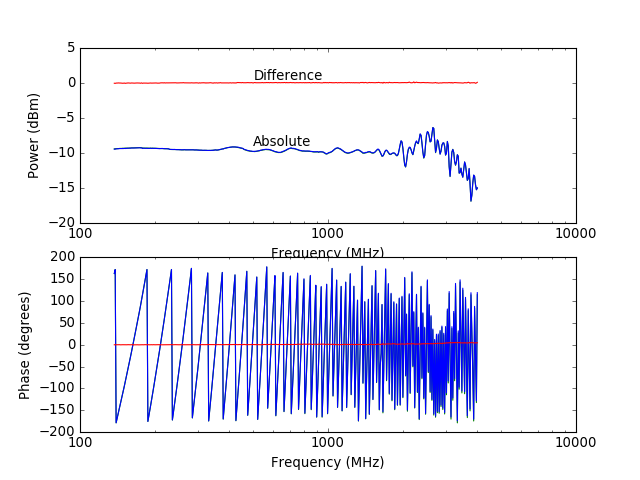

In [2]:
ref_raw = Span().load('01-ref.txt', "Reference signal")
ref_2_raw = Span().load('01-ref-2.txt', "Reference signal")
ref = ref_2_raw - ref_raw

g = Graph()
g.plot(ref_raw, color = 'g')
g.plot(ref_2_raw, color = 'b')
g.plot(ref, "Difference", color = 'r')
g.ax.text(500, 0.4, 'Difference')
g.ax.text(500, -9.0, 'Absolute')
g.show(0)

Zoom in on the difference.  It's less than 0.2 dB which I consider decent.

<IPython.core.display.Javascript object>


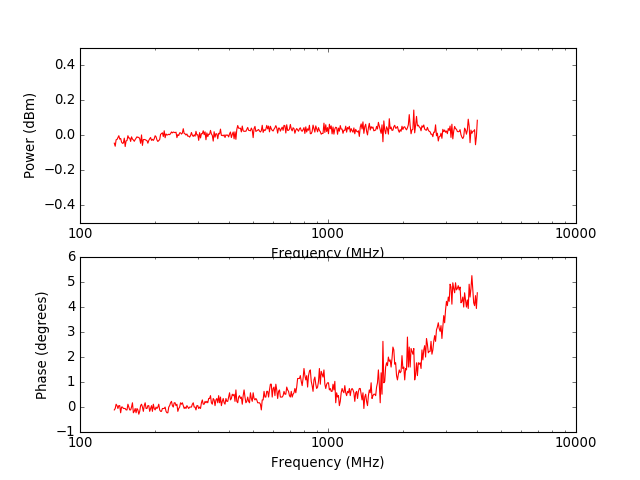

In [3]:
g = Graph()
g.ax.set_ylim(-0.5, 0.5)
g.plot(ref, "Difference", color = 'r')
g.show(0)

Load a sample from using a 20dB attenuator in series with the reference signal.  Take the difference to get a fairly nice plot of the frequency response of the attenuator itself.  The noise rises sharply above about 2GHz though.

<IPython.core.display.Javascript object>


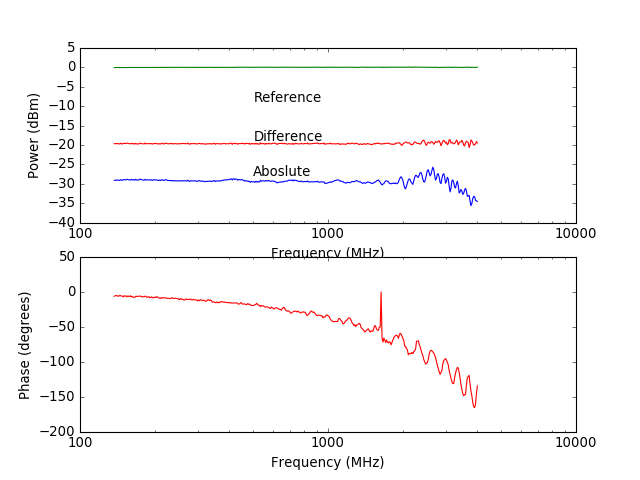

In [4]:
atten20_raw = Span().load('02-attenuator-20.txt', "Reference signal via -20dB attenuator")
atten20 = atten20_raw - ref_raw

g = Graph()
g.plot(ref, show_phase = False)
g.handle[0].set_color('g')
g.plot(atten20_raw, show_phase = False)
g.handle[0].set_color('b')
g.plot(atten20, show_phase = True)
g.handle[0].set_color('r')
g.ax.text(500, -19, 'Difference')
g.ax.text(500, -9.0, 'Reference')
g.ax.text(500, -28.0, 'Aboslute')
g.show(0)

Measure 20dB, 30dB, 40dB and 50dB attenuators by plotting difference from reference signal.

<IPython.core.display.Javascript object>


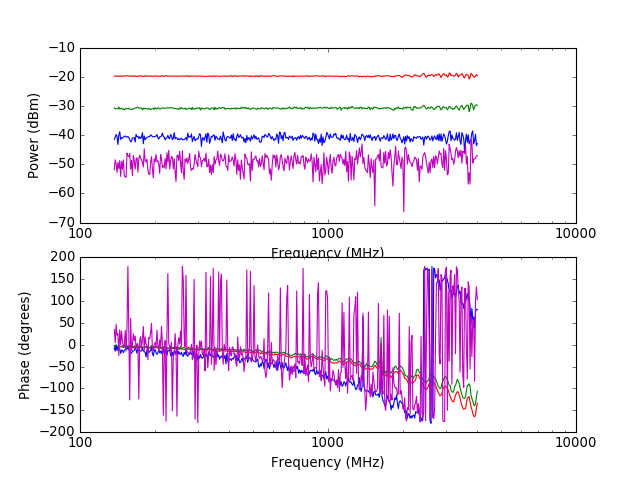

In [5]:
atten30_raw = Span().load('03-attenuator-30.txt', "Reference signal via -30dB attenuator")
atten30 = atten30_raw - ref_raw
atten40_raw = Span().load('04-attenuator-40.txt', "Reference signal via -40dB attenuator")
atten40 = atten40_raw - ref_raw
atten50_raw = Span().load('05-attenuator-50.txt', "Reference signal via -50dB attenuator")
atten50 = atten50_raw - ref_raw

# The 40dB attenuator is actually a 30dB and a 10dB attenuator in series
# The 50dB attenuator is actually a 30dB and a 20dB attenuator in series

g = Graph()
g.plot(atten20, color = 'r')
g.plot(atten30, color = 'g')
g.plot(atten40, color = 'b')
g.plot(atten50, color = 'm')
g.show(0)

Load samples when the probe has been connected.

The dotted red trace is the raw signal when the probe was attached.  The solid red trace is the difference between the reference signal before and after the probe was connected and shows how much the probe loads the signal.

<IPython.core.display.Javascript object>


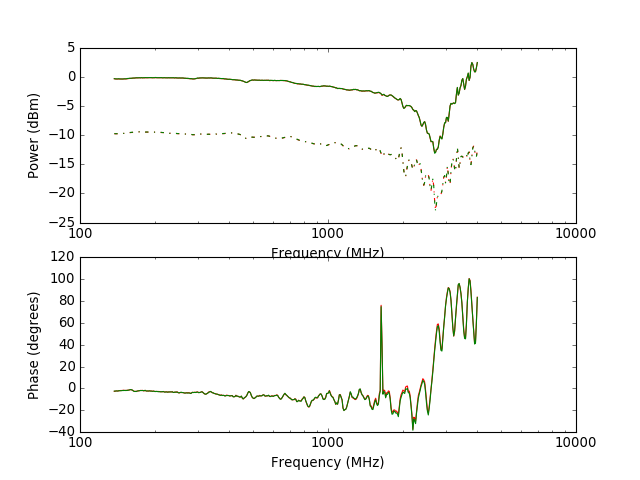

In [6]:
ref_probe_raw = Span().load('06-ref-with-probe.txt', "Reference signal with probe attached")
ref_probe = ref_probe_raw - ref_raw
ref_probe_raw_2 = Span().load('06-ref-with-probe-2.txt', "Reference signal with probe attached")
ref_probe_2 = ref_probe_raw_2 - ref_raw

g = Graph()
g.plot(ref_probe_raw, show_phase = False, color = 'r', linestyle = '-.')
g.plot(ref_probe, color = 'r')
g.plot(ref_probe_raw_2, show_phase = False, color = 'g', linestyle = '-.')
g.plot(ref_probe_2, "Load", color = 'g')
g.show(0)

The dotted green, blue and magenta traces show the raw measurements of the output from the probe.  The solid traces show the difference after subracting the reference signal when the probe was attached.  The noise rises above 2GHz, both because the measurements become noisy at high frequencies and because the signal is attenuated to close to the noise floor.

<IPython.core.display.Javascript object>


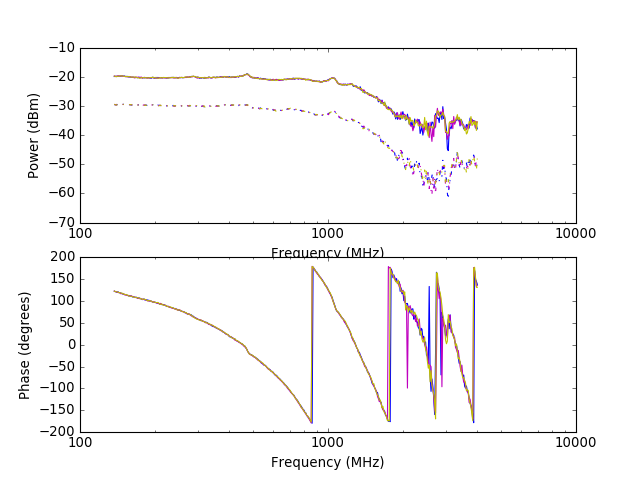

In [7]:
probe_out_raw = Span().load('07-probe-out.txt', "Probe output")
probe_out = probe_out_raw - ref_probe_raw
probe_out_2_raw = Span().load('07-probe-out-2.txt', "Probe output")
probe_out_2 = probe_out_2_raw - ref_probe_raw
probe_out_3_raw = Span().load('07-probe-out-3.txt', "Probe output")
probe_out_3 = probe_out_3_raw - ref_probe_raw

g = Graph()
g.plot(probe_out_raw, show_phase = False, color = 'b', linestyle = '-.')
g.plot(probe_out, color = 'b')
g.plot(probe_out_2_raw, show_phase = False, color = 'm', linestyle = '-.')
g.plot(probe_out_2, color = 'm')
g.plot(probe_out_3_raw, show_phase = False, color = 'y', linestyle = '-.')
g.plot(probe_out_3, color = 'y')
g.show(0)

Show amplifier plots.

Note that the 20dB amplifier only amplifies 18dB:

https://en.wikipedia.org/wiki/Gain_compression